# Lab2 Classification
## The Simpsons Characters Recognition Challenge II

In [1]:
# import sys 
# sys.path.append("C:\\Users\\USER\\Documents\\NYCU\\DL\\Lab2")

In [2]:
from dataloader import SimpsonsLoader
from torch.utils.data import DataLoader
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import csv
from tqdm import tqdm
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
batch_size = 64
epochs = 10
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4
num_classes = 50
criterion = nn.CrossEntropyLoss()
image_size=(224,224)
path = "saved_model/pre_resnet18_v1"

isExist = os.path.exists(path)
if not isExist:
   os.makedirs(path)
   
# criterion = nn.BCELoss()
# optimizer = optim.SGD(Net.parameters(), lr = learning_rate, momentum = momentum, weight_decay=weight_decay)

## Define Model Class

In [5]:
class DeepConvNet(nn.Module):

    def __init__(self, act = "ELU") -> None:
        super(DeepConvNet, self).__init__()

        self.C = 2
        self.T = 750
        self.N = 2

        self.conv1 = nn.Conv2d(3, 25, kernel_size=(1, 5), stride=(1, 1), padding='valid', bias=True)
        self.conv2 = nn.Conv2d(25, 25, kernel_size=(self.C, 1), stride=(1, 1), padding='valid', bias=True)
        self.bn1 = nn.BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.conv3 = nn.Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1), padding='valid', bias=True)
        self.bn2 = nn.BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.conv4 = nn.Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1), padding='valid', bias=True)
        self.bn3 = nn.BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.conv5 = nn.Conv2d(100, 200, kernel_size=(1, 5), stride=(1, 1), padding='valid', bias=True)
        self.bn4 = nn.BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.maxpool = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
        self.dropout = nn.Dropout(p=0.5)
        self.dense = nn.Linear(in_features=200*43, out_features=num_classes, bias=True)
        if (act == "RELU"):
            self.act = nn.ReLU()
        elif (act == "leakyRELU"):
            self.act = nn.LeakyReLU()
        else:
            self.act = nn.ELU()

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.act(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.conv5(x)
        x = self.bn4(x)
        x = self.act(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = x.view(-1, 200*43)
        x = self.dense(x)

        return x
    
    def record_history(self, loss_history, train_accuracy_history, test_accuracy_history):
        self.loss_history = loss_history
        self.train_accuracy_history = train_accuracy_history
        self.test_accuracy_history = test_accuracy_history

In [6]:
class EEGNet(nn.Module):

    def __init__(self, act = "ELU"):
        super(EEGNet, self).__init__()
        
        if (act == "RELU"):
            self.act = nn.ReLU()
        elif (act == "leakyRELU"):
            self.act = nn.LeakyReLU()
        else:
            self.act = nn.ELU(alpha=1.0)
        
        self.firstConv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=(0, 25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            self.act,
            nn.AvgPool2d(kernel_size=3, stride=1, padding=0),
            nn.Dropout(p=0.25)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=(0, 7), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            self.act,
            nn.AvgPool2d(kernel_size=3, stride=1, padding=0),
            nn.Dropout(p=0.25)
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=223*4, out_features=num_classes, bias=True)
        )

    def forward(self, x):
        
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(-1, 223*4)
        x = self.classify(x)
        
        return x
    
    def record_history(self, loss_history, train_accuracy_history, test_accuracy_history):
        self.loss_history = loss_history
        self.train_accuracy_history = train_accuracy_history
        self.test_accuracy_history = test_accuracy_history

In [7]:
# ref: https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)


In [8]:
class ResBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, stride=1)
        self.shortcut = nn.Sequential()
        
        if self.downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if self.downsample else 1),
                nn.BatchNorm2d(out_channels)
            )

        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = nn.ReLU()(self.bn3(self.conv3(input)))
        input = input + shortcut
        return nn.ReLU()(input)


In [9]:
class ResNet(nn.Module):

    def __init__(self, in_channels, resblock, repeat, useBottleneck=False, outputs=1000) -> None:
        super(ResNet, self).__init__()

        self.loss_history = []
        self.train_accuracy_history = []
        self.test_accuracy_history = []

        if useBottleneck:
            self.filters = [64, 256, 512, 1024, 2048]
        else:
            self.filters = [64, 64, 128, 256, 512]

        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )

        self.layer1 = nn.Sequential()
        self.layer1.add_module('conv1_1', resblock(self.filters[0], self.filters[1], downsample=False))
        for i in range(1, repeat[0]):
                self.layer1.add_module('conv1_%d'%(i+1,), resblock(self.filters[1], self.filters[1], downsample=False))

        self.layer2 = nn.Sequential()
        self.layer2.add_module('conv2_1', resblock(self.filters[1], self.filters[2], downsample=True))
        for i in range(1, repeat[1]):
                self.layer2.add_module('conv2_%d' % (i+1,), resblock(self.filters[2], self.filters[2], downsample=False))

        self.layer3 = nn.Sequential()
        self.layer3.add_module('conv3_1', resblock(self.filters[2], self.filters[3], downsample=True))
        for i in range(1, repeat[2]):
            self.layer3.add_module('conv3_%d' % (i+1,), resblock(self.filters[3], self.filters[3], downsample=False))

        self.layer4 = nn.Sequential()
        self.layer4.add_module('conv4_1', resblock(self.filters[3], self.filters[4], downsample=True))
        for i in range(1, repeat[3]):
            self.layer4.add_module('conv4_%d'%(i+1,), resblock(self.filters[4], self.filters[4], downsample=False))
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        # self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)
        self.fc = nn.Linear(in_features=self.filters[4], out_features=outputs, bias=True)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
    def record_history(self, loss_history, train_accuracy_history, test_accuracy_history):
        if loss_history is not None:
            self.loss_history.append(loss_history)
        self.train_accuracy_history.append(train_accuracy_history)
        self.test_accuracy_history.append(test_accuracy_history)

## Datasets

### Transform

In [10]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transforms=transforms.Compose([
    transforms.Resize(image_size),
    # transforms.RandomApply(transforms=[transforms.RandomCrop(image_size, padding=(40,40,40,40), pad_if_needed=False)], p=0.5),
    transforms.RandomApply(transforms=[transforms.RandomAffine(degrees=(-30,30), translate=(0.15,0.15), scale=(0.9,1.3), shear=(0,20))],p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    normalize
])

test_transforms=transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    normalize
])

### Load Datasets

In [11]:
train_data = SimpsonsLoader(".", "train", train_transforms)

n_train = len(train_data)
split = n_train // 3
indices = list(range(n_train))
random.shuffle(indices)

train_sampler = SubsetRandomSampler(indices[split:])
valid_sampler = SubsetRandomSampler(indices[:split])

train_loader = DataLoader(train_data, batch_size, shuffle=False, drop_last=False, 
                            sampler=train_sampler, num_workers=4, prefetch_factor=4)

valid_loader = DataLoader(train_data, batch_size, shuffle=False, drop_last=False, 
                            sampler=valid_sampler, num_workers=4, prefetch_factor=4)


> Found 96929 images...


## Train/Test Functions

In [12]:
def evaluate(model, dataloader, batch_size, ispretrained=False):
    results = []
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), 
                ncols=200, desc=f'Evaluation: ')
    for step, (inputs, labels) in pbar:

        inputs = inputs.to(device)
        labels = labels.cpu().numpy()
        # inputs = Variable(torch.from_numpy(inputs).to(device, dtype=torch.float).cuda(0))
        pred = model(inputs)
        predicted = torch.argmax(pred, dim=1).flatten().cpu().numpy()
        results.append((predicted == labels).astype(float).sum())
        
    result = sum(results)/len(dataloader)/batch_size
    
    return result

In [13]:
def train(train_loader, test_loader, model, optimizer, epochs, path, ispretrained=False):
    best_test_acc = -np.inf

    for epo in range(epochs):  # loop over the dataset multiple times
        # Training
        # print("epoch", epo)
        model.train()
        running_loss = 0.0
        epoch = epo+1
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), 
                    ncols=200, desc=f'Epoch {epoch:3d}: ')

        for step, (x, y) in pbar:

            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            result = model(x)
            loss = criterion(result, y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # torch.save(model, f"./{path}/epo{epoch}_bf_eval.pth")

        # Validation accuracy
        model.eval()
        print("eval training data")
        accuracy_train = evaluate(model, train_loader, batch_size, ispretrained)
        print ("Train - ", accuracy_train)
        print("eval testing data")
        accuracy_test = evaluate(model, test_loader, batch_size, ispretrained)
        print ("Test - ", accuracy_test)

        if accuracy_test > best_test_acc:
            best_test_acc = accuracy_test
            print("epoch:", epoch, ", best_test_acc:", best_test_acc)
            torch.save(model, f"./{path}/best_accuracy_at_epo{epoch}.pth")

        torch.save(model, f"./{path}/epo{epoch}.pth")


In [14]:
def get_prediction_result(model, dataloader):
    model.eval()
    prediction=torch.tensor([])
    labels = torch.tensor([])
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), 
                ncols=100, desc=f'Evaluation: ')
    for step, (x, y) in pbar:
        x = x.float().cuda(device)
        y = y.long().cuda(device)
        result = model(x)
        batch_prediction=result.argmax(dim=1).cpu()
        prediction=torch.cat([prediction, batch_prediction])
        labels=torch.cat([labels, y.cpu()])
    return prediction.numpy(), labels.numpy()


In [29]:
def get_prediction_result_wo_label(model, test_data):
    model.eval()
    prediction=torch.tensor([])
    # pbar = tqdm(enumerate(test_data), total=len(test_data), 
    #             ncols=100, desc=f'Evaluation: ')
    for (x, _) in test_data:
        x = torch.unsqueeze(x, 0).float().cuda(device)
        result = model(x)
        batch_prediction=result.argmax(dim=1).cpu()
        prediction=torch.cat([prediction, batch_prediction])

    return prediction.numpy()

In [16]:
# from math import ceil, floor

# def train(net, optimizer):
#     loss_history = []
#     accuracy_train_history = []
#     accuracy_test_history = []

#     for epoch in range(epochs):  # loop over the dataset multiple times
#         print ("\nEpoch ", epoch)
        
#         running_loss = 0.0
#         for i in range(ceil(len(train_data)/batch_size)):
#             # print ("\nBatch ", i)
#             s = i*batch_size
#             e = min(i*batch_size+batch_size, len(train_data))
            
#             inputs = torch.from_numpy(train_data[s:e])
#             labels = torch.FloatTensor(np.array([train_label[s:e]]).T*1.0)
#             inputs = inputs.to(device, dtype=torch.float)
#             labels = labels.to(device, dtype=torch.long)
            
#             # wrap them in Variable
#             inputs, labels = Variable(inputs.cuda(0), requires_grad=True), Variable(labels.cuda(0))

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             # print(inputs.shape)
#             outputs = net(inputs)
#             # print(outputs.shape, labels.shape)
#             # print(outputs)
#             # print(labels.flatten())
#             # for x in zip(outputs, labels):
#             #     print(x)
                
#             loss = criterion(outputs, labels.flatten())
#             # print(loss)
#             # loss = Variable(loss, requires_grad = True)
#             loss.backward()
            
#             optimizer.step()
#             running_loss += loss.item()
#             # running_loss += loss.data[0]
        
#         # Validation accuracy
#         params = ["acc", "auc", "fmeasure"]
#         # print (params)
#         loss_history.append(running_loss)
#         accuracy_train_history.append(evaluate(net, train_data, train_label, params))
#         accuracy_test_history.append(evaluate(net, test_data, test_label, params))
#         print ("Training Loss ", running_loss)
#         print ("Train - ", accuracy_train_history[-1])
#         # print ("Validation - ", evaluate(EEGnet, X_val, y_val, params))
#         print ("Test - ", accuracy_test_history[-1])

#     net.record_history(loss_history, accuracy_train_history, accuracy_test_history)


## Training & Evaluation

In [17]:
# EEGnet_ELU = EEGNet("ELU")
# EEGnet_RELU = DeepConvNet("RELU")
# EEGnet_leakyRELU = DeepConvNet("leakyRELU")

# EEGnet_ELU.to(device)
# EEGnet_RELU.to(device)
# EEGnet_leakyRELU.to(device)

# EEGnet_ELU = EEGnet_ELU.float()
# EEGnet_RELU = EEGnet_RELU.float()
# EEGnet_leakyRELU = EEGnet_leakyRELU.float()

In [18]:
# DCnet_ELU = DeepConvNet("ELU")
# DCnet_RELU = DeepConvNet("RELU")
# DCnet_leakyRELU = DeepConvNet("leakyRELU")

# DCnet_ELU.to(device)
# DCnet_RELU.to(device)
# DCnet_leakyRELU.to(device)

# DCnet_ELU = DCnet_ELU.float()
# DCnet_RELU = DCnet_RELU.float()
# DCnet_leakyRELU = DCnet_leakyRELU.float()

In [19]:
# pre-trained
pre_resnet18 = models.resnet18(pretrained = True)
pre_resnet18.fc = nn.Linear(512, num_classes)
pre_resnet18.to(device)


# resnet18 = ResNet(3, ResBlock, [2, 2, 2, 2], useBottleneck=False, outputs=num_classes)
# resnet18.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))


c:\Users\USER\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
model = pre_resnet18
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay=weight_decay)
# optimizer = optim.Adam(model.parameters(), lr = learning_rate)
train(train_loader, valid_loader, model, optimizer, epochs, path)
torch.save(model, os.path.join(path, "modelv1.pth"))

Epoch   1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [03:59<00:00,  4.22it/s]


eval training data


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [01:33<00:00, 10.85it/s]


Train -  15.323514851485148
eval testing data


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:47<00:00, 10.62it/s]


Test -  15.205940594059406
epoch: 0 , best_test_acc: 15.205940594059406


Epoch   2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [03:33<00:00,  4.72it/s]


eval training data


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [01:17<00:00, 13.08it/s]


Train -  15.601980198019803
eval testing data


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:31<00:00, 15.84it/s]


Test -  15.456435643564356
epoch: 1 , best_test_acc: 15.456435643564356


Epoch   3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [03:37<00:00,  4.64it/s]


eval training data


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [01:37<00:00, 10.35it/s]


Train -  15.769059405940594
eval testing data


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:53<00:00,  9.38it/s]


Test -  15.636138613861386
epoch: 2 , best_test_acc: 15.636138613861386


Epoch   4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [03:49<00:00,  4.39it/s]


eval training data


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [01:41<00:00,  9.92it/s]


Train -  15.836633663366337
eval testing data


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:53<00:00,  9.48it/s]


Test -  15.698514851485148
epoch: 3 , best_test_acc: 15.698514851485148


Epoch   5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [03:47<00:00,  4.44it/s]


eval training data


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [01:43<00:00,  9.73it/s]


Train -  15.74430693069307
eval testing data


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:54<00:00,  9.27it/s]


Test -  15.594059405940595


Epoch   6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [04:10<00:00,  4.03it/s]


eval training data


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [01:38<00:00, 10.20it/s]


Train -  15.81980198019802
eval testing data


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:51<00:00,  9.87it/s]


Test -  15.694059405940594


Epoch   7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [03:52<00:00,  4.34it/s]


eval training data


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [01:49<00:00,  9.19it/s]


Train -  15.840841584158415
eval testing data


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [01:02<00:00,  8.08it/s]


Test -  15.699009900990099
epoch: 6 , best_test_acc: 15.699009900990099


Epoch   8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [03:40<00:00,  4.58it/s]


eval training data


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [01:31<00:00, 11.10it/s]


Train -  15.890841584158416
eval testing data


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:46<00:00, 10.78it/s]


Test -  15.784158415841585
epoch: 7 , best_test_acc: 15.784158415841585


Epoch   9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [03:16<00:00,  5.15it/s]


eval training data


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [01:31<00:00, 11.05it/s]


Train -  15.732920792079208
eval testing data


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:45<00:00, 11.02it/s]


Test -  15.572277227722772


Epoch  10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [03:15<00:00,  5.16it/s]


eval training data


Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [01:40<00:00, 10.02it/s]


Train -  15.827227722772276
eval testing data


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:46<00:00, 10.95it/s]


Test -  15.661881188118812


## Load Model

In [17]:
model = torch.load(f"saved_model/pre_resnet18_v1/best_accuracy.pth")
model.require_grad=False
# print("eval testing data")
# accuracy_test = evaluate(model, valid_loader, batch_size)
# print ("Test - ", accuracy_test)

In [18]:
# char_dict = {}
char_list = []
with open('./dataset/character_label.csv', 'r', newline='\n') as file:
    rows = csv.reader(file)
    next(rows)
    for row in rows:
        char_list.append(row[1])
    file.close()

In [19]:
print(char_list)

['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'brandine_spuckler', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'dolph_starbeam', 'duff_man', 'edna_krabappel', 'fat_tony', 'gary_chalmers', 'gil', 'groundskeeper_willie', 'homer_simpson', 'jimbo_jones', 'kearney_zzyzwicz', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'lunchlady_doris', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'timothy_lovejoy', 'troy_mcclure', 'waylon_smithers']


In [20]:
test_prediction, test_label = get_prediction_result(model, valid_loader)
print('length of data: ', len(test_label))

Evaluation: 100%|█████████████████████████████████████████████████| 505/505 [01:03<00:00,  7.96it/s]

length of data:  32309


In [21]:
conf_matrix=confusion_matrix(test_label, test_prediction, normalize='true')
print('Total Acc', sum([conf_matrix[i][i] for i in range(num_classes) ]) / num_classes)
print(conf_matrix)

Total Acc 0.9916706474463131
[[0.99707602 0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.99146515 ... 0.         0.00142248 0.        ]
 ...
 [0.         0.         0.         ... 0.9884106  0.         0.        ]
 [0.         0.         0.         ... 0.         0.98387097 0.        ]
 [0.         0.0016     0.         ... 0.         0.         0.9888    ]]


In [22]:
# disp = ConfusionMatrixDisplay.from_predictions(test_label, test_prediction, xticks_rotation='vertical', include_values=False, display_labels=char_list)
# fig, ax = plt.subplots(figsize=(30,30))
# disp.plot(ax=ax)
# plt.savefig(os.path.join(path, "confusion_matrix.png"))

c:\Users\USER\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'brandine_spuckler', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'dolph_starbeam', 'duff_man', 'edna_krabappel', 'fat_tony', 'gary_chalmers', 'gil', 'groundskeeper_willie', 'homer_simpson', 'jimbo_jones', 'kearney_zzyzwicz', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'lunchlady_doris', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'timothy_lovejoy', 'troy_mcclure', 'waylon_smithers'] as key

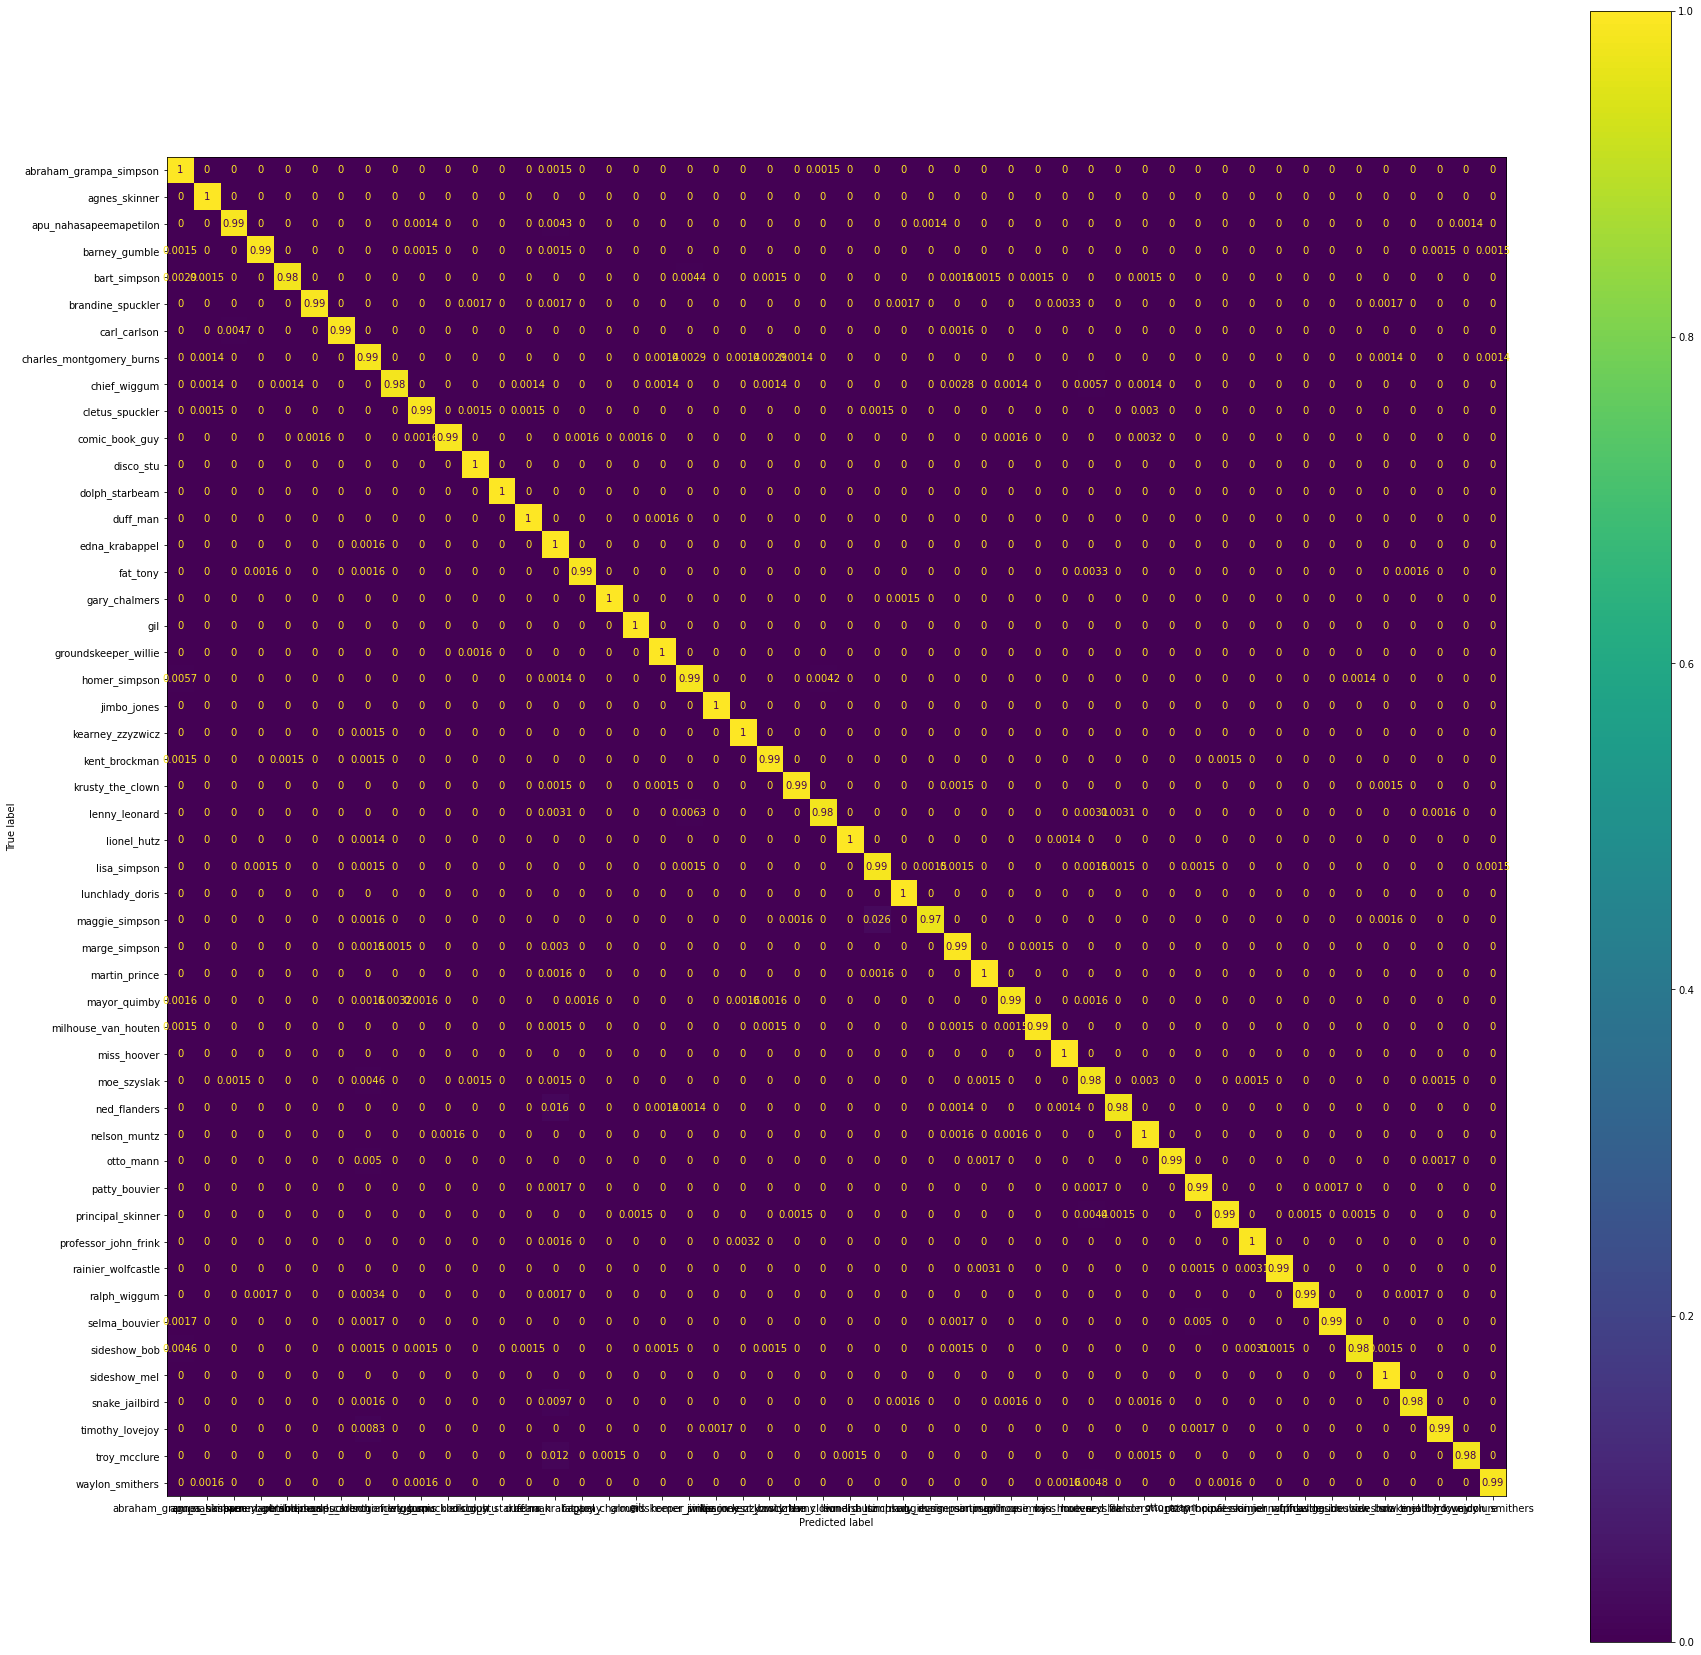

In [23]:
disp=ConfusionMatrixDisplay(conf_matrix, char_list)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.savefig(os.path.join(path, "confusion_matrix_normal.png"))

In [39]:
model.require_grad=False

test_data = SimpsonsLoader(".", "test", test_transforms)
# test_loader = DataLoader(test_data, batch_size, shuffle=False, drop_last=False, 
#                             num_workers=4, prefetch_factor=4)
# iter = enumerate(test_loader)
# print(next(iter))

> Found 10791 images...


In [40]:
test_prediction = get_prediction_result_wo_label(model, test_data)
print('length of result: ', len(test_prediction))

length of result:  10791


In [41]:
print(test_prediction[:20])

[17. 11. 38.  7. 26. 29. 24. 21. 46. 25. 35.  8.  8. 43. 35. 16. 43. 23.
 16. 25.]


In [42]:
with open('./dataset/submission_v1.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id", "character"])
    for i, p in enumerate(test_prediction):
        writer.writerow([i+1, char_list[int(p)]])
    file.close()